This code computes the probability of nonlinear Breit-Wheeler pair production by an arbitrary $A_\mu(t,x)$, assuming only that it vanishes as any of the coordinates goes to infinity, using the scattered-wave-function method in:

*Momentum correlation in pair production by spacetime dependent fields from scattered wave functions*

arXiv:2509.17770

and 

*Solving the Dirac equation on a GPU for strong-field processes in multidimensional background fields*

to appear.

G. Torgrimsson

# Import

diffrax contains the ODE solver for solving the Dirac equation on a GPU.

In [1]:
# %%capture output
# %pip install diffrax

In [2]:
import jax
import jax.numpy as np
from diffrax import diffeqsolve, ODETerm, Dopri5, PIDController, SaveAt, SubSaveAt

import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import make_interp_spline, RegularGridInterpolator
from tqdm import tqdm

import sympy as sp
from sympy.plotting import plot

In [3]:
precision=64

if precision==32:
    realType=np.float32
    compType=np.complex64

elif precision==64:
    jax.config.update("jax_enable_x64", True)
    realType=np.float64
    compType=np.complex128

In [4]:
def toMathematica(arr):
  mathematica_str=str(arr.tolist()).replace('[','{').replace(']','}').replace("e","*10^").replace("j","I").replace("(","").replace(")","")
  print(mathematica_str)

In [5]:
#def chop(x, tol=1e-7)
@jax.jit
def chop(x, tol=1e-10):
    return np.where(np.abs(x) < tol, 0.0, x)

In [6]:
@jax.jit
def simpson_jax(y, dx=1.0):
    n = y.shape[-1]
    if n % 2 == 1:
        # Odd number of samples → pure Simpson's 1/3 rule
        return (dx/3) * (
            y[..., 0]
            + 4 * np.sum(y[..., 1:-1:2], axis=-1)
            + 2 * np.sum(y[..., 2:-2:2], axis=-1)
            + y[..., -1]
        )
    else:
        # Even number of samples → use Simpson's 1/3 on first n-3, 3/8 on last 4
        y_main = y[..., :-3]
        y_tail = y[..., -4:]

        main = (dx/3) * (
            y_main[..., 0]
            + 4 * np.sum(y_main[..., 1:-1:2], axis=-1)
            + 2 * np.sum(y_main[..., 2:-2:2], axis=-1)
            + y_main[..., -1]
        )

        tail = (3*dx/8) * (
            y_tail[..., 0]
            + 3 * y_tail[..., 1]
            + 3 * y_tail[..., 2]
            + y_tail[..., 3]
        )

        return main + tail

In [7]:
from datetime import datetime
import time
from IPython import get_ipython

start_time = time.perf_counter()

In [8]:
def pre_run_cell(info):
    global start_time
    start_time = time.perf_counter()

def post_run_cell(result):
    end_time = time.perf_counter()
    elapsed = end_time - start_time
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | elapsed time: {elapsed:.3f} s")

ip = get_ipython()
ip.events.register('pre_run_cell', pre_run_cell)
ip.events.register('post_run_cell', post_run_cell)

2025-12-17 12:02:19 | elapsed time: 0.008 s


# Canonical example

The field and the scattered wave function should be contained in $-x_b<x,y,z<x_b$. $n_x$ is the number of points in the $x$, $y$ and $z$ directions. $n_k$ ($\geq n_x$) is the number of points in the Fourier space.   

$-D_0\psi=(\gamma^0\gamma^k D_k+i\gamma^0)\psi$, where $D_\mu=\partial_\mu+iA_\mu$, so
$-\partial_t\psi=(iA_0+i\beta+\alpha^k\partial_k+iA_k\alpha^k)\psi$

In [ ]:
# xDim=1

# # simple gauge

# gamma=1
# E0=1/3
# omega=gamma*E0
# kappa=gamma*E0

# def A0(t,x,y,z):
#   return (E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

# def A1(t,x,y,z):
#   return 0

# def A2(t,x,y,z):
#   return 0

# def A3(t,x,y,z):
#   return 0

# xb=25; nx=201; nk=303
# tin=-12; tout=10

2025-12-15 15:05:32 | elapsed time: 0.001 s


In [12]:
# # another gauge for checking gauge invariance

# gamma=1
# E0=1/3
# omega=gamma*E0
# kappa=gamma*E0

# def A0(t,x,y,z):
#   return (1+omega*omega*t)*(E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

# def A1(t,x,y,z):
#   return (kappa*kappa*x)*(E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

# def A2(t,x,y,z):
#   return (kappa*kappa*y)*(E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

# def A3(t,x,y,z):
#   return (kappa*kappa*z)*(E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

2025-12-15 15:05:32 | elapsed time: 0.000 s


# One dominant peak

In [11]:
xDim=1

gamma=1
#E0=1/4
E0=1/6
omega=gamma*E0
kappa=gamma*E0/2

sig=-1

def A0(t,x,y,z):
  return -sig*(E0/kappa)*np.sin(kappa*x)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2+z**2))

def A1(t,x,y,z):
  return 0

def A2(t,x,y,z):
  return 0

def A3(t,x,y,z):
  return 0


tin=-3.2/omega; tout=-tin

# past lightcone should be contained in (-xb,xb):
xb=3.2/kappa+tout

nx=501; nk=801
#nx=256; nk=300

[tout,xb]

[19.200000000000003, 57.60000000000001]

2025-12-17 12:02:58 | elapsed time: 0.003 s


Check gauge invariance using:

In [12]:
# def A0(t,x,y,z):
#   return -sig*(E0/kappa)*(np.sin(kappa*x)+omega**2*t)*np.exp(-(omega*t)**2-(kappa*x)**2)

# def A1(t,x,y,z):
#   return -sig*(E0/kappa)*(kappa**2*x)*np.exp(-(omega*t)**2-(kappa*x)**2)

2025-12-17 12:02:58 | elapsed time: 0.000 s


# spin and polarization

In [13]:
spinAxis=1

gDim=4

if spinAxis==1:
  g0=np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])
  g3=np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[-1,0,0,0]])
  g2=np.array([[0,0,0,-1j],[0,0,1j,0],[0,1j,0,0],[-1j,0,0,0]])
  g1=np.array([[0,0,1,0],[0,0,0,-1],[-1,0,0,0],[0,1,0,0]])
  id=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

  g=[g0,g1,g2,g3]
  eta=np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])

  alpha1=g0@g1; alpha2=g0@g2; alpha3=g0@g3; beta=g0;

  def uab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (P0*g0[a,b]+P1*g1[a,b]+P2*g2[a,b]+P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P1))

  def vab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (-P0*g0[a,b]-P1*g1[a,b]-P2*g2[a,b]-P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P1))


elif spinAxis==2:
  g0=np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])
  g1=np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[-1,0,0,0]])
  g3=np.array([[0,0,0,-1j],[0,0,1j,0],[0,1j,0,0],[-1j,0,0,0]])
  g2=np.array([[0,0,1,0],[0,0,0,-1],[-1,0,0,0],[0,1,0,0]])
  id=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

  g=[g0,g1,g2,g3]
  eta=np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])

  alpha1=g0@g1; alpha2=g0@g2; alpha3=g0@g3; beta=g0;

  def uab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (P0*g0[a,b]+P1*g1[a,b]+P2*g2[a,b]+P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P2))

  def vab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (-P0*g0[a,b]-P1*g1[a,b]-P2*g2[a,b]-P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P2))
    

elif spinAxis==3:
  g0=np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])
  g1=np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[-1,0,0,0]])
  g2=np.array([[0,0,0,-1j],[0,0,1j,0],[0,1j,0,0],[-1j,0,0,0]])
  g3=np.array([[0,0,1,0],[0,0,0,-1],[-1,0,0,0],[0,1,0,0]])
  id=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

  g=[g0,g1,g2,g3]
  eta=np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])

  alpha1=g0@g1; alpha2=g0@g2; alpha3=g0@g3; beta=g0;

  def uab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (P0*g0[a,b]+P1*g1[a,b]+P2*g2[a,b]+P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P3))

  def vab(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (-P0*g0[a,b]-P1*g1[a,b]-P2*g2[a,b]-P3*g3[a,b]+id[a,b])/np.sqrt(2*P0*(P0+P3))

2025-12-17 12:03:00 | elapsed time: 0.618 s


In [14]:
u1rest=np.array([uab(0,0,0,a,1) for a in range(gDim)])
u2rest=np.array([uab(0,0,0,a,2) for a in range(gDim)])

v1rest=np.array([vab(0,0,0,a,1) for a in range(gDim)])
v2rest=np.array([vab(0,0,0,a,2) for a in range(gDim)])

print(
np.array([
    np.conjugate(u1rest)@(1j*g2@g3)@u1rest,
    np.conjugate(u1rest)@(1j*g3@g1)@u1rest,
    np.conjugate(u1rest)@(1j*g1@g2)@u1rest
])
)

print(
np.array([
    np.conjugate(u2rest)@(1j*g2@g3)@u2rest,
    np.conjugate(u2rest)@(1j*g3@g1)@u2rest,
    np.conjugate(u2rest)@(1j*g1@g2)@u2rest
])
)

print(
np.array([
    np.conjugate(v1rest)@(1j*g2@g3)@v1rest,
    np.conjugate(v1rest)@(1j*g3@g1)@v1rest,
    np.conjugate(v1rest)@(1j*g1@g2)@v1rest
])
)

print(
np.array([
    np.conjugate(v2rest)@(1j*g2@g3)@v2rest,
    np.conjugate(v2rest)@(1j*g3@g1)@v2rest,
    np.conjugate(v2rest)@(1j*g1@g2)@v2rest
])
)

[1.+0.j 0.+0.j 0.+0.j]
[-1.+0.j  0.+0.j  0.+0.j]
[1.+0.j 0.+0.j 0.+0.j]
[-1.+0.j  0.+0.j  0.+0.j]
2025-12-17 12:03:01 | elapsed time: 1.452 s


In [15]:
for i in range(4):
  for j in range(4):
    if i==j:
      print(np.abs(chop((g[i]@g[j]+g[j]@g[i]-2*id*eta[i,j]))).ravel())
    else:
      print(np.abs(chop((g[i]@g[j]+g[j]@g[i]))).ravel())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2025-12-17 12:03:02 | elapsed time: 0.457 s


In [16]:
for i in range(4):
  print(np.abs(g[i].conj().T-g0@g[i]@g0).ravel())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2025-12-17 12:03:02 | elapsed time: 0.206 s


In [17]:
p1ex=-.35; p2ex=.11; p3ex=-.2; p0ex=np.sqrt(1+p1ex**2+p2ex**2+p3ex**2)
q1ex=-p1ex; q2ex=-p2ex; q3ex=-p3ex; q0ex=np.sqrt(1+q1ex**2+q2ex**2+q3ex**2)

u1ex=np.array([uab(p1ex,p2ex,p3ex,a,1) for a in range(gDim)])
u2ex=np.array([uab(p1ex,p2ex,p3ex,a,2) for a in range(gDim)])
v1ex=np.array([vab(q1ex,q2ex,q3ex,a,1) for a in range(gDim)])
v2ex=np.array([vab(q1ex,q2ex,q3ex,a,2) for a in range(gDim)])

uvEx=[u1ex,u2ex,v1ex,v2ex]

2025-12-17 12:03:02 | elapsed time: 0.244 s


In [18]:
for i in range(4):
  for j in range(4):
    if i==j:
      print(chop(np.abs(np.conjugate(uvEx[i])@uvEx[j]-1)), end=" ")
    else:
      print(chop(np.abs(np.conjugate(uvEx[i])@uvEx[j])), end=" ")
  print()

0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 
2025-12-17 12:03:02 | elapsed time: 0.129 s


In [19]:
print(chop(np.abs((p0ex*g0+p1ex*g1+p2ex*g2+p3ex*g3-id)@u1ex)))
print(chop(np.abs((p0ex*g0+p1ex*g1+p2ex*g2+p3ex*g3-id)@u2ex)))
print(chop(np.abs((q0ex*g0+q1ex*g1+q2ex*g2+q3ex*g3+id)@v1ex)))
print(chop(np.abs((q0ex*g0+q1ex*g1+q2ex*g2+q3ex*g3+id)@v2ex)))

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
2025-12-17 12:03:03 | elapsed time: 0.372 s


$(Q_0\gamma^0+Q_k\gamma^k+1)\psi^{+}({\bf Q})=0
\qquad
(-Q_0\gamma^0+Q_k\gamma^k+1)\psi^{-}({\bf Q})=0$

$\frac{1}{Q_0}(Q_k\alpha^k+\beta)\psi^{+}({\bf Q})=-\psi^{+}({\bf Q})
\qquad
\frac{1}{Q_0}(Q_k\alpha^k+\beta)\psi^{-}({\bf Q})=\psi^{-}({\bf Q})$

$\Lambda^{+}=\frac{1}{2Q_0}(Q_0-Q_k\alpha^k-\beta)
\qquad
\Lambda^{-}=\frac{1}{2Q_0}(Q_0+Q_k\alpha^k+\beta)$

In [20]:
def LambdaPlus(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (P0*id[a,b]-P1*alpha1[a,b]-P2*alpha2[a,b]-P3*alpha3[a,b]-beta[a,b])/(2*P0)

def LambdaMinus(P1,P2,P3,a,b):
    P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)
    return (P0*id[a,b]+P1*alpha1[a,b]+P2*alpha2[a,b]+P3*alpha3[a,b]+beta[a,b])/(2*P0)

2025-12-17 12:03:03 | elapsed time: 0.001 s


Fourier defined as $\psi(t,{\bf x})=\int\frac{{\rm d}^3{\bf Q}}{(2\pi)^3}\psi(t,{\bf Q})e^{iQ_jx^j}$, so ${\bf Q}=-{\bf p}$ for $U$

In [21]:
pPlusEx=np.array([[LambdaPlus(-p1ex,-p2ex,-p3ex,a,b) for b in range(gDim)] for a in range(gDim)])
pMinusEx=np.array([[LambdaMinus(-p1ex,-p2ex,-p3ex,a,b) for b in range(gDim)] for a in range(gDim)])

qPlusEx=np.array([[LambdaPlus(q1ex,q2ex,q3ex,a,b) for b in range(gDim)] for a in range(gDim)])
qMinusEx=np.array([[LambdaMinus(q1ex,q2ex,q3ex,a,b) for b in range(gDim)] for a in range(gDim)])

2025-12-17 12:03:03 | elapsed time: 0.307 s


In [22]:
print(chop(np.abs(pMinusEx@u1ex-u1ex)))
print(chop(np.abs(pPlusEx@u1ex)))

print(chop(np.abs(pMinusEx@u2ex-u2ex)))
print(chop(np.abs(pPlusEx@u2ex)))

print(chop(np.abs(qPlusEx@v1ex-v1ex)))
print(chop(np.abs(qMinusEx@v1ex)))

print(chop(np.abs(qPlusEx@v2ex-v2ex)))
print(chop(np.abs(qMinusEx@v2ex)))

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
2025-12-17 12:03:03 | elapsed time: 0.041 s


In [23]:
def epsilon(k1,k2,k3,e1,e2,e):
    k0=np.sqrt(k1**2+k2**2+k3**2)
    mk=np.sqrt(k2**2+k3**2)
    if e==0:
        return -e1*mk/k0
    elif e==1:
        return e1*k1*k2/(mk*k0)-e2*k3/mk
    elif e==2:
        return e1*k1*k3/(mk*k0)+e2*k2/mk

def epsilonVec(k1,k2,k3,e1,e2):
    return np.array([epsilon(k1,k2,k3,e1,e2,e) for e in range(3)])

2025-12-17 12:03:03 | elapsed time: 0.001 s


In [24]:
k1ex=1.2; k2ex=-1.7; k3ex=.8; k0ex=np.sqrt(k1ex**2+k2ex**2+k3ex**2)
kEx=np.array([k1ex,k2ex,k3ex])/k0ex
paraEx=epsilonVec(k1ex,k2ex,k3ex,1,0)
perpEx=epsilonVec(k1ex,k2ex,k3ex,0,1)

2025-12-17 12:03:03 | elapsed time: 0.163 s


In [25]:
print(chop(np.cross(paraEx,perpEx)-kEx))
print(chop(np.cross(perpEx,kEx)-paraEx))
print(chop(np.cross(kEx,paraEx)-perpEx))

print(chop(np.array([np.dot(paraEx,paraEx)-1,np.dot(perpEx,perpEx)-1,np.dot(perpEx,paraEx),np.dot(perpEx,kEx),np.dot(paraEx,kEx)])))

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0. 0. 0.]
2025-12-17 12:03:04 | elapsed time: 0.285 s


# Padding: Grid and ODE define

In [26]:
x0=-xb; x1=xb; dx=(x1-x0)/(nx-1)
xGrid=np.linspace(x0,x1,nx)
dk=2*np.pi/(nk*dx); 
nkHalf=nk//2; kMax=dk*(nk-1)/2
kGrid=2*np.pi*np.fft.fftfreq(nk,dx)
nPad=(nk-nx)//2
xMin=((nk-1)/(nx-1))*x0
nxH=nx//2

psiOut=np.zeros(2*gDim*(nx**xDim),dtype=realType)

if xDim==1:
  X=xGrid; Y=0; Z=0;
  K1=kGrid; K2=0; K3=0;
elif xDim==2:
  X,Y=np.meshgrid(xGrid,xGrid,indexing='ij')
  Z=0
  K1,K2=np.meshgrid(kGrid,kGrid,indexing='ij')
  K3=0
elif xDim==3:
  X,Y,Z=np.meshgrid(xGrid,xGrid,xGrid,indexing='ij')
  K1,K2,K3=np.meshgrid(kGrid,kGrid,kGrid,indexing='ij')

kShift=np.fft.fftshift(kGrid)

if xDim==1:
  K1s=kShift; K2s=0; K3s=0;
elif xDim==2:
  K1s,K2s=np.meshgrid(kShift,kShift,indexing='ij')
  K3s=0
elif xDim==3:
  K1s,K2s,K3s=np.meshgrid(kShift,kShift,kShift,indexing='ij')

Ushape=[gDim]+xDim*[nx]

2025-12-17 12:03:30 | elapsed time: 0.356 s


The spatial derivatives, $\partial_i$, are calculated by Fourier transforming, multiplying by $k_i$, and then Fourier transforming back to $x^i$.

dPsi gives the right-hand side of the Dirac equation for the scattered wave, $\partial_t\psi_\text{scat.}=dPsi$. There is a minus sign because we integrate backwards in time.

In [27]:
yShape=[2,gDim]+xDim*[nx]
unPad=tuple(slice(nPad,-nPad) for _ in range(xDim))

def makeDer(P1,P2,P3,spin,sign):
  P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)

  if sign==1:
    uOut=[uab(P1,P2,P3,a,spin) for a in range(gDim)]
  elif sign==-1:
    uOut=[vab(P1,P2,P3,a,spin) for a in range(gDim)]

  if xDim==1:
    B=1j*beta-1j*sign*(P2*alpha2+P3*alpha3)
  elif xDim==2:
    B=1j*beta-1j*sign*(P3*alpha3)
  elif xDim==3:
    B=1j*beta

  @jax.jit
  def dPsi(t,y,args):
    y=y.reshape(yShape)
    dy = [np.zeros(xDim*[nx],dtype=compType) for _ in range(gDim)]
    A0ar=chop(A0(t,X,Y,Z))
    A1ar=chop(A1(t,X,Y,Z))
    A2ar=chop(A2(t,X,Y,Z))
    A3ar=chop(A3(t,X,Y,Z))

    for b in range(gDim):
      phi=y[0,b]+1j*y[1,b]
      phi2=phi+uOut[b]*np.exp(-1j*sign*(P0*t+P1*X+P2*Y+P3*Z))
      dy[b]=dy[b]+1j*A0ar*phi2
      der=np.fft.ifftn(np.pad(phi,nPad))
      for a in range(gDim):
        dy[a]=dy[a]+B[a,b]*phi+np.fft.fftn(-1j*(alpha1[a,b]*K1+alpha2[a,b]*K2+alpha3[a,b]*K3)*der)[unPad]
        dy[a]=dy[a]+1j*(alpha1[a,b]*A1ar+alpha2[a,b]*A2ar+alpha3[a,b]*A3ar)*phi2

    for a in range(gDim):
      dy[a]=-chop(dy[a])

    dy=np.concatenate(dy)
    return np.concatenate([np.real(dy),np.imag(dy)]).ravel()

  return dPsi

2025-12-17 12:03:30 | elapsed time: 0.001 s


# No padding: Grid and ODE define

In [ ]:
# x0=-xb; x1=xb; dx=(x1-x0)/(nx-1)
# xGrid=np.linspace(x0,x1,nx)
# dk=2*np.pi/(nk*dx); kMax=dk*(nk-1)/2
# kGrid=2*np.pi*np.fft.fftfreq(nk,dx)
# nPad=(nk-nx)//2
# nH=round((nx-1)/2)

# psiOut=np.zeros(2*gDim*(nx**xDim),dtype=realType)

# if xDim==1:
#   X=xGrid; Y=0; Z=0;
#   K1=kGrid; K2=0; K3=0;
# elif xDim==2:
#   X,Y=np.meshgrid(xGrid,xGrid,indexing='ij',sparse=True)
#   Z=0
#   K1,K2=np.meshgrid(kGrid,kGrid,indexing='ij',sparse=True)
#   K3=0
# elif xDim==3:
#   X,Y,Z=np.meshgrid(xGrid,xGrid,xGrid,indexing='ij',sparse=True)
#   K1,K2,K3=np.meshgrid(kGrid,kGrid,kGrid,indexing='ij',sparse=True)

# Ushape=[gDim]+xDim*[nx]

2025-12-14 13:03:02 | elapsed time: 0.004 s


The spatial derivatives, $\partial_i$, are calculated by Fourier transforming, multiplying by $k_i$, and then Fourier transforming back to $x^i$.
dPsi gives the right-hand side of the Dirac equation for the scattered wave, $\partial_t\psi_\text{scat.}=dPsi$. There is a minus sign because we integrate backwards in time.

In [ ]:
# yShape=[2,gDim]+xDim*[nx]

# def makeDer(P1,P2,P3,spin,sign):
#   P0=np.sqrt(1+P1*P1+P2*P2+P3*P3)

#   if sign==1:
#     uOut=[uab(P1,P2,P3,a,spin) for a in range(gDim)]
#   elif sign==-1:
#     uOut=[vab(P1,P2,P3,a,spin) for a in range(gDim)]

#   if xDim==1:
#     B=1j*beta-1j*sign*(P2*alpha2+P3*alpha3)
#   elif xDim==2:
#     B=1j*beta-1j*sign*(P3*alpha3)
#   elif xDim==3:
#     B=1j*beta

#   @jax.jit
#   def dPsi(t,y,args):
#     y=y.reshape(yShape)
#     dy = [np.zeros(xDim*[nx],dtype=compType) for _ in range(gDim)]
#     A0ar=chop(A0(t,X,Y,Z))
#     A1ar=chop(A1(t,X,Y,Z))
#     A2ar=chop(A2(t,X,Y,Z))
#     A3ar=chop(A3(t,X,Y,Z))

#     for b in range(gDim):
#       phi=y[0,b]+1j*y[1,b]
#       phi2=phi+uOut[b]*np.exp(-1j*sign*(P0*t+P1*X+P2*Y+P3*Z))
#       dy[b]=dy[b]+1j*A0ar*phi2
#       der=np.fft.ifftn(phi)
#       for a in range(gDim):
#         dy[a]=dy[a]+B[a,b]*phi+np.fft.fftn(-1j*(alpha1[a,b]*K1+alpha2[a,b]*K2+alpha3[a,b]*K3)*der)
#         dy[a]=dy[a]+1j*(alpha1[a,b]*A1ar+alpha2[a,b]*A2ar+alpha3[a,b]*A3ar)*phi2

#     for a in range(gDim):
#       dy[a]=-chop(dy[a])

#     dy=np.concatenate(dy)
#     return np.concatenate([np.real(dy),np.imag(dy)]).ravel()

#   return dPsi

2025-12-14 13:03:02 | elapsed time: 0.001 s


# Fourier define

$x[j]=x_0+jdx$, $j=0,...,n_x-1$ and $dx=\frac{x_1-x_0}{n_x-1}$

After padding with $n_p=\frac{n_k-n_x}{2}$ zeros on all sides:
$x[j]=x_{\rm min}+jdx$, $j=0,...,n_k-1$, where $x_{\rm min}=\frac{n_k-1}{n_x-1}x_0$


unshifted: $k[l]=l dk$, $l=0,...,n_k-1$ and $dk=\frac{2\pi}{n_kdx}$

shifted, odd $n_k$: $l=-\frac{n_k-1}{2},...,\frac{n_k-1}{2} \quad\to\quad -k_{\rm min}=k_{\rm max}=dk\frac{n_k-1}{2}$

$f(t,{\bf q})=\int{\rm d}^D{\bf x}\,f(t,{\bf x})e^{-iq_jx^j}=dx^D e^{-iq_j x_{\rm min}^j}{\rm fft}(f)$


$f(t,{\bf x})=\int\frac{{\rm d}^D{\bf q}}{(2\pi)^D}f(t,{\bf q})e^{iq_jx^j}=\left(\frac{dk}{2\pi}\right)^D e^{iq_j^{\rm min}x^j}{\rm ifft}(f,\text{norm="forward"})$

In [28]:
if nPad==0:

  @jax.jit
  def fourierXtoQ(f):
    fFFT=np.exp(-1j*(K1+K2+K3)*xMin)*np.fft.fftn(f)
    return (dx**xDim)*np.fft.fftshift(fFFT)

else:

  @jax.jit
  def fourierXtoQ(f):
    fFFT=np.pad(f,nPad)
    fFFT=np.exp(-1j*(K1+K2+K3)*xMin)*np.fft.fftn(fFFT)
    return (dx**xDim)*np.fft.fftshift(fFFT)

2025-12-17 12:03:36 | elapsed time: 0.001 s


In [29]:
xa, qa = sp.symbols('xa qa', real=True)
fxa = (1+xa/3-xa**2/5)*sp.exp(-(xa-1)**2/10)
integrand = fxa * sp.exp(-sp.I * qa * xa)
fka = sp.integrate(integrand, (xa, -sp.oo, sp.oo))
fka = fka.simplify()

fxa_jax= sp.lambdify(xa, fxa, 'jax')
fxa_list=fxa_jax(xGrid)

fka_jax= sp.lambdify(qa, fka, 'jax')
fka_list=fka_jax(kShift)

fka

sqrt(10)*sqrt(pi)*(5*qa**2 + I*qa/3 + 2/15)*exp(-qa*(5*qa/2 + I))

2025-12-17 12:03:37 | elapsed time: 1.572 s


In [30]:
# plt.plot(xGrid,fxa_list)

2025-12-17 12:03:37 | elapsed time: 0.000 s


In [31]:
# plot(sp.re(fxa),(xa,-10,10))

2025-12-17 12:03:37 | elapsed time: 0.001 s


In [32]:
# plot(sp.im(fka),(qa,-10,10))

2025-12-17 12:03:37 | elapsed time: 0.001 s


In [33]:
fXtoQcheck=fourierXtoQ(fxa_list)

2025-12-17 12:03:37 | elapsed time: 0.086 s


In [34]:
np.max(np.abs(fXtoQcheck-fka_list))

Array(6.31813477e-14, dtype=float64)

2025-12-17 12:03:37 | elapsed time: 0.151 s


In [35]:
xa, qa = sp.symbols('xa qa', real=True)
fka = (-2+qa**3/4)*sp.exp(-(qa-1)**2)
integrand = fka * sp.exp(sp.I * qa * xa)/(2*sp.pi)
fxa = sp.integrate(integrand, (qa, -sp.oo, sp.oo))
fxa = fxa.simplify()

fka_jax= sp.lambdify(qa, fka, 'jax')
fka_list=fka_jax(kShift)

fxa_jax= sp.lambdify(xa, fxa, 'jax')
fxa_list=fxa_jax(xGrid)

fxa

(-I*xa**3 - 6*xa**2 + 18*I*xa - 44)*exp(xa*(-xa/4 + I))/(64*sqrt(pi))

2025-12-17 12:03:39 | elapsed time: 1.358 s


In [36]:
fXtoQcheck=fourierXtoQ(fxa_list)

2025-12-17 12:03:39 | elapsed time: 0.064 s


In [37]:
np.max(np.abs(fXtoQcheck-fka_list))

Array(5.27705879e-14, dtype=float64)

2025-12-17 12:03:39 | elapsed time: 0.035 s


# Partial integration in time, define

In [38]:
no=3
psiOut2=np.zeros(2*2*gDim*(nx**xDim)+2*no,dtype=realType)
solver = Dopri5()
controller = PIDController(rtol=1e-6, atol=1e-10)

@jax.jit
def atime(t, y, args):
    return np.array([y[-2*j-2]+1j*y[-2*j-1] for j in range(no)])

saveat = SaveAt(t1=True, fn=atime)

sign=np.array([-1,1])

    

@jax.jit
def doAll(k1,k2,k3,p1,p2,p3,q1,q2,q3,pol,uSpin,vSpin):

    p0=np.sqrt(1+p1**2+p2**2+p3**2)
    q0=np.sqrt(1+q1**2+q2**2+q3**2)
    uSpinor=np.array([uab(p1,p2,p3,a,uSpin) for a in range(gDim)])
    vSpinor=np.array([vab(q1,q2,q3,a,vSpin) for a in range(gDim)])

    k0=np.sqrt(k1**2+k2**2+k3**2)

    e1 = np.where(pol == 1, 1, 0)
    e2 = np.where(pol == 2, 1, 0)
    eps=epsilonVec(k1,k2,k3,e1,e2)
    polMat=eps[0]*alpha1+eps[1]*alpha2+eps[2]*alpha3

    Uproj=np.array([
        [[LambdaMinus(K1s,-p2,-p3,a,b) for b in range(gDim)] for a in range(gDim)],
        [[LambdaPlus(K1s,-p2,-p3,a,b) for b in range(gDim)] for a in range(gDim)]
        ])

    Vproj=np.array([
        [[LambdaMinus(K1s+k1,q2,q3,a,b) for b in range(gDim)] for a in range(gDim)],
        [[LambdaPlus(K1s+k1,q2,q3,a,b) for b in range(gDim)] for a in range(gDim)]
        ])
        

    P0s=np.sqrt(1+K1s**2+p2**2+p3**2)
    Q0s=np.sqrt(1+(K1s+k1)**2+(-p2+k2)**2+(-p3+k3)**2)

    def tScatScat(t,U,V,dU,dV):

        qInt=0

        Uf=np.array([fourierXtoQ(U[a]) for a in range(gDim)])
        Vf=np.array([fourierXtoQ(V[a]*np.exp(-1j*(k1*X+k2*Y+k3*Z))) for a in range(gDim)])

        Up=np.einsum('sija,ja->sia',Uproj,Uf)
        Up=np.conj(Up)
        Vp=np.einsum('sija,ja->sia',Vproj,Vf)

        Uf=np.array([fourierXtoQ(dU[a]) for a in range(gDim)])
        Vf=np.array([fourierXtoQ(dV[a]*np.exp(-1j*(k1*X+k2*Y+k3*Z))) for a in range(gDim)])

        dUp=np.einsum('sija,ja->sia',Uproj,Uf)
        dUp=np.conj(dUp)                
        dVp=np.einsum('sija,ja->sia',Vproj,Vf)

        for sU in range(2):
            for sV in range(2):
                pre=1j*np.exp(-1j*k0*t)/(-sign[sU]*P0s+sign[sV]*Q0s-k0)

                qGrand=pre*np.einsum('ia,ij,ja->a',dUp[sU],polMat,Vp[sV])
                qGrand+=pre*np.einsum('ia,ij,ja->a',Up[sU],polMat,dVp[sV])

                pre=1j*(sign[sU]*P0s-sign[sV]*Q0s)*pre
                qGrand+=pre*np.einsum('ia,ij,ja->a',Up[sU],polMat,Vp[sV])

                qInt+=simpson_jax(qGrand,dk/(2*np.pi))

        return np.array([np.real(qInt),np.imag(qInt)])
    

    def tBackScat(t,V,dV):

        Q0=np.sqrt(1+(-p1+k1)**2+q2**2+q3**2)
        qInt=0

        Vproj0=np.array([
        [[LambdaMinus(-p1+k1,q2,q3,a,b) for b in range(gDim)] for a in range(gDim)],
        [[LambdaPlus(-p1+k1,q2,q3,a,b) for b in range(gDim)] for a in range(gDim)]
        ])

        Vf=np.array([simpson_jax(V[a]*np.exp(-1j*((-p1+k1)*X+(-p2+k2)*Y+(-p3+k3)*Z)),dx) for a in range(gDim)])
        Vp=np.einsum('sij,j->si',Vproj0,Vf)

        Vf=np.array([simpson_jax(dV[a]*np.exp(-1j*((-p1+k1)*X+(-p2+k2)*Y+(-p3+k3)*Z)),dx) for a in range(gDim)])
        dVp=np.einsum('sij,j->si',Vproj0,Vf)

        for sV in range(2):
            qInt+=np.einsum('i,ij,j->',np.conj(uSpinor),polMat,-1j*sign[sV]*Q0*Vp[sV]+dVp[sV])*1j*np.exp(1j*(p0-k0)*t)/(p0+sign[sV]*Q0-k0)

        return np.array([np.real(qInt),np.imag(qInt)])
    

    def tScatBack(t,U,dU):

        P0=np.sqrt(1+(q1-k1)**2+p2**2+p3**2)
        qInt=0

        Uproj0=np.array([
        [[LambdaMinus(q1-k1,-p2,-p3,a,b) for b in range(gDim)] for a in range(gDim)],
        [[LambdaPlus(q1-k1,-p2,-p3,a,b) for b in range(gDim)] for a in range(gDim)]
        ])

        Uf=np.array([simpson_jax(U[a]*np.exp(-1j*((q1-k1)*X+(q2-k2)*Y+(q3-k3)*Z)),dx) for a in range(gDim)])
        Up=np.einsum('sij,j->si',Uproj0,Uf)
        Up=np.conj(Up)

        Uf=np.array([simpson_jax(dU[a]*np.exp(-1j*((q1-k1)*X+(q2-k2)*Y+(q3-k3)*Z)),dx) for a in range(gDim)])
        dUp=np.einsum('sij,j->si',Uproj0,Uf)
        dUp=np.conj(dUp)

        for sU in range(2):
            qInt+=np.einsum('i,ij,j->',1j*sign[sU]*P0*Up[sU]+dUp[sU],polMat,vSpinor)*1j*np.exp(1j*(q0-k0)*t)/(-sign[sU]*P0+q0-k0)

        return np.array([np.real(qInt),np.imag(qInt)])
    


    UdPsi=makeDer(p1,p2,p3,uSpin,1)
    VdPsi=makeDer(q1,q2,q3,vSpin,-1)
    
    def combined(t, y, args):
        U, V = np.split(y[:-2*no], 2)
        dUf = UdPsi(t, U, args)
        dVf = VdPsi(t, V, args)

        U=U.reshape(yShape)
        V=V.reshape(yShape)
        U=U[0]+1j*U[1]
        V=V[0]+1j*V[1]

        dU=dUf.reshape(yShape)
        dV=dVf.reshape(yShape)
        dU=dU[0]+1j*dU[1]
        dV=dV[0]+1j*dV[1]

        tScatScat0 = tScatScat(t,U,V,dU,dV)
        tBackScat0 = tBackScat(t,V,dV)
        tScatBack0 = tScatBack(t,U,dU)

        return np.concatenate([dUf, dVf, tScatScat0, tBackScat0, tScatBack0])

    term=ODETerm(combined)
    sol = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-1,y0=psiOut2,
        stepsize_controller=controller,saveat=saveat)

    #solP=np.abs(np.sum(sol.ys[0]))**2
    solP=np.sum(sol.ys[0])
    #return np.concat([np.array([solP]),np.flip(sol.ys[0])])
    return solP

2025-12-17 12:03:57 | elapsed time: 0.055 s


# Checking waves

In [39]:
[nx,nk,tout,xb,kappa*dx,dk,kMax]

[501,
 801,
 19.200000000000003,
 57.60000000000001,
 0.019200000000000002,
 0.03404590457229887,
 13.618361828919548]

2025-12-17 11:47:47 | elapsed time: 0.002 s


In [40]:
uSpin0=1; vSpin0=1

UdPsi=makeDer(p1,p2,p3,uSpin0,1)
term=ODETerm(UdPsi)
solutionU = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-1,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(t1=True))

Uscatr,Uscati=np.split(solutionU.ys[-1],2)
Uscat=Uscatr+1j*Uscati
Uscat=Uscat.reshape(Ushape)


VdPsi=makeDer(q1,q2,q3,vSpin0,-1)
term=ODETerm(VdPsi)
solutionV = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(t1=True))

Vscatr,Vscati=np.split(solutionV.ys[-1],2)
Vscat=Vscatr+1j*Vscati
Vscat=Vscat.reshape(Ushape)

2025-12-17 11:47:55 | elapsed time: 4.805 s


In [ ]:
plt.plot(xGrid,np.real(Vscat[1]))

Check that the scattered waves are contained in $(-x_b,x_b)$:

In [42]:
np.abs(Uscat[:,0])

Array([7.91653215e-10, 2.41878489e-06, 1.45179914e-06, 5.52248547e-06],      dtype=float64)

2025-12-17 11:48:04 | elapsed time: 0.052 s


In [43]:
np.abs(Uscat[:,-1])

Array([5.91493744e-10, 3.27527002e-06, 1.96610473e-06, 7.48758642e-06],      dtype=float64)

2025-12-17 11:48:08 | elapsed time: 0.039 s


In [44]:
np.abs(Vscat[:,0])

Array([4.25665587e-10, 6.41826447e-06, 3.85146431e-06, 3.81920099e-06],      dtype=float64)

2025-12-17 11:48:12 | elapsed time: 0.004 s


In [45]:
np.abs(Vscat[:,-1])

Array([4.88562837e-10, 4.73286727e-06, 2.84017852e-06, 2.81900470e-06],      dtype=float64)

2025-12-17 11:48:24 | elapsed time: 0.005 s


# Partial integration in time, compute

In [39]:
k1=0; k2=1.2; k3=0
p1=.6; p2=.5*k2; p3=0
q1=-p1; q2=k2-p2; q3=k3-p3

2025-12-17 12:04:05 | elapsed time: 0.000 s


In [40]:
combos = np.array(
    [(pol, uSpin, vSpin)
     for pol in (1,2)
     for uSpin in (1,2)
     for vSpin in (1,2)]
)

def doAll_wrapper(args):
    pol, uSpin, vSpin = args
    return doAll(k1, k2, k3, p1, p2, p3, q1, q2, q3,
                 pol, uSpin, vSpin)

batched_doAll = jax.jit(jax.vmap(doAll_wrapper))

results = batched_doAll(combos)

para = results[:4].reshape(2,2)  
perp = results[4:].reshape(2,2)

2025-12-17 12:04:22 | elapsed time: 15.176 s


In [48]:
[spinAxis,E0,sig,nx,nk,tout,xb,kappa*dx,dk,kMax]

[1,
 0.16666666666666666,
 -1,
 501,
 801,
 19.200000000000003,
 57.60000000000001,
 0.019200000000000002,
 0.03404590457229887,
 13.618361828919548]

2025-12-17 11:09:10 | elapsed time: 0.002 s


In [49]:
para1=para
para1

Array([[-0.10470657+0.25045692j,  0.15027407+0.06282395j],
       [ 0.15027407+0.06282395j, -0.10470657+0.25045692j]],      dtype=complex128)

2025-12-17 11:09:25 | elapsed time: 0.004 s


Check analytical spin dependence: 

In [52]:
np.abs(para[0,1]/(-1j*p2*para[0,0])-1)

Array(5.38576378e-07, dtype=float64)

2025-12-17 11:10:20 | elapsed time: 0.139 s


In [53]:
perp1=perp
perp1

Array([[ 0.07546395-0.18035144j,  0.06282428-0.15027376j],
       [-0.06282428+0.15027376j, -0.07546395+0.18035144j]],      dtype=complex128)

2025-12-17 11:10:27 | elapsed time: 0.004 s


In [54]:
np.abs(perp[0,1]/(-1j*para[0,1])-1)

Array(2.75506146e-06, dtype=float64)

2025-12-17 11:10:29 | elapsed time: 0.006 s


In [83]:
spinAxis

2

2025-12-17 11:11:36 | elapsed time: 0.002 s


In [84]:
para2=para
para2

Array([[ 5.31540428e-15+1.21287032e-14j, -1.22107930e-01+2.92080159e-01j],
       [ 1.22107930e-01-2.92080159e-01j,  4.88995453e-15-7.14709134e-16j]],      dtype=complex128)

2025-12-17 11:11:39 | elapsed time: 0.004 s


Summing over spins should give the same result regardless of spin basis:

In [85]:
np.sum(np.abs(para1)**2)/np.sum(np.abs(para2)**2)-1

Array(1.14141624e-06, dtype=float64)

2025-12-17 11:11:46 | elapsed time: 0.144 s


In [86]:
perp2=perp
perp2

Array([[ 0.03223074-0.19060502j,  0.16503983+0.01196281j],
       [ 0.16503983+0.01196281j, -0.03223074+0.19060502j]],      dtype=complex128)

2025-12-17 11:11:51 | elapsed time: 0.005 s


In [87]:
np.sum(np.abs(perp1)**2)/np.sum(np.abs(perp2)**2)-1

Array(3.03629802e-06, dtype=float64)

2025-12-17 11:11:55 | elapsed time: 0.006 s


In [116]:
spinAxis

3

2025-12-17 11:12:53 | elapsed time: 0.003 s


In [117]:
para3=para
para3

Array([[-5.95320776e-15+7.50394763e-15j, -1.22107705e-01+2.92080560e-01j],
       [ 1.22107705e-01-2.92080560e-01j, -1.63161140e-14-8.93064360e-15j]],      dtype=complex128)

2025-12-17 11:12:56 | elapsed time: 0.005 s


In [118]:
np.abs(para3-para2)

Array([[1.21807217e-14, 4.59592846e-07],
       [4.59592909e-07, 2.27420078e-14]], dtype=float64)

2025-12-17 11:13:02 | elapsed time: 0.057 s


In [119]:
perp3=perp
perp3

Array([[ 0.02921949+0.04927471j, -0.10692008+0.03842899j],
       [-0.10692008+0.03842899j,  0.16342541-0.2714664j ]],      dtype=complex128)

2025-12-17 11:13:05 | elapsed time: 0.004 s


In [120]:
np.sum(np.abs(perp1)**2)/np.sum(np.abs(perp3)**2)-1

Array(4.69026225e-07, dtype=float64)

2025-12-17 11:13:06 | elapsed time: 0.005 s


Check precision with fewer points

In [183]:
[spinAxis,E0,sig,nx,nk,tout,xb,kappa*dx,dk,kMax]

[1,
 0.16666666666666666,
 -1,
 256,
 300,
 19.200000000000003,
 57.60000000000001,
 0.037647058823529415,
 0.04636030825609937,
 6.930866084286856]

2025-12-17 11:16:22 | elapsed time: 0.002 s


In [184]:
para1check=para
np.abs(para1/para1check-1)

Array([[2.38456102e-06, 1.07991963e-06],
       [1.08338797e-06, 2.38525408e-06]], dtype=float64)

2025-12-17 11:16:27 | elapsed time: 0.005 s


In [185]:
perp1check=perp
np.abs(perp1/perp1check-1)

Array([[5.62377422e-06, 1.60464940e-06],
       [1.60311638e-06, 5.62762083e-06]], dtype=float64)

2025-12-17 11:16:30 | elapsed time: 0.004 s


Check gauge invariance:

In [48]:
[spinAxis,E0,sig,nx,nk,tout,xb,kappa*dx,dk,kMax,A1(0,1/kappa,0,0)]

[1,
 0.16666666666666666,
 -1,
 501,
 801,
 19.200000000000003,
 57.60000000000001,
 0.019200000000000002,
 0.03404590457229887,
 13.618361828919548,
 Array(0.06131324, dtype=float64, weak_type=True)]

2025-12-17 11:49:37 | elapsed time: 0.045 s


In [51]:
np.abs(para/np.array([[-0.10470657+0.25045692j,  0.15027407+0.06282395j],
       [ 0.15027407+0.06282395j, -0.10470657+0.25045692j]])-1)

Array([[2.13723287e-06, 1.45288386e-06],
       [1.45288393e-06, 2.13723278e-06]], dtype=float64)

2025-12-17 11:51:02 | elapsed time: 0.094 s


In [52]:
np.abs(perp/np.array([[ 0.07546395-0.18035144j,  0.06282428-0.15027376j],
       [-0.06282428+0.15027376j, -0.07546395+0.18035144j]])-1)

Array([[1.17616228e-06, 3.74214478e-06],
       [3.74214476e-06, 1.17616232e-06]], dtype=float64)

2025-12-17 11:52:35 | elapsed time: 0.004 s


# plots

In [43]:
k1=0; k2=1.2; k3=0
p1=.6; p2=.5*k2; p3=0
q1=-p1; q2=k2-p2; q3=k3-p3

2025-12-17 12:05:20 | elapsed time: 0.000 s


In [44]:
np.abs(para/np.array([[-0.10470657+0.25045692j,  0.15027407+0.06282395j],
       [ 0.15027407+0.06282395j, -0.10470657+0.25045692j]])-1)

Array([[1.79289806e-08, 3.21780166e-08],
       [3.21780362e-08, 1.79289643e-08]], dtype=float64)

2025-12-17 12:05:23 | elapsed time: 0.004 s


In [45]:
np.abs(perp/np.array([[ 0.07546395-0.18035144j,  0.06282428-0.15027376j],
       [-0.06282428+0.15027376j, -0.07546395+0.18035144j]])-1)

Array([[1.91977118e-08, 3.24103616e-08],
       [3.24101987e-08, 1.91976775e-08]], dtype=float64)

2025-12-17 12:05:25 | elapsed time: 0.004 s


In [48]:
[spinAxis,E0,sig,nx,nk,tout,xb,kappa*dx,dk,kMax,A1(0,1/kappa,0,0)]

[1,
 0.16666666666666666,
 -1,
 501,
 801,
 19.200000000000003,
 57.60000000000001,
 0.019200000000000002,
 0.03404590457229887,
 13.618361828919548,
 0]

2025-12-17 12:07:05 | elapsed time: 0.002 s


In [50]:
pmin=-.5; pmax=1.5; dp=(pmax-pmin)/100.
pList=np.arange(pmin,pmax+dp,dp)

2025-12-17 12:07:57 | elapsed time: 0.002 s


In [51]:
batched_doAll = jax.jit(jax.vmap(lambda p: doAll(k1,k2,k3,p,p2,p3,-p,q2,q3,1,1,1)))
tabB = batched_doAll(pList)
tabB=np.array(tabB)

2025-12-17 12:08:33 | elapsed time: 35.321 s


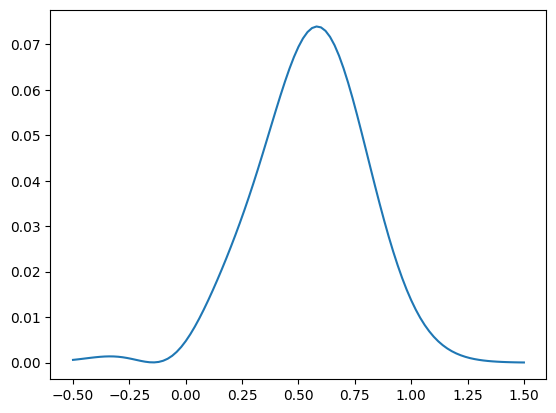

2025-12-17 12:08:35 | elapsed time: 0.075 s


In [52]:
plt.plot(pList,np.abs(tabB)**2)

In [53]:
toMathematica(pList)

{-0.5, -0.48, -0.45999999999999996, -0.43999999999999995, -0.41999999999999993, -0.3999999999999999, -0.3799999999999999, -0.3599999999999999, -0.33999999999999986, -0.31999999999999984, -0.2999999999999998, -0.2799999999999998, -0.2599999999999998, -0.23999999999999977, -0.21999999999999975, -0.19999999999999973, -0.17999999999999972, -0.1599999999999997, -0.13999999999999968, -0.11999999999999966, -0.09999999999999964, -0.07999999999999963, -0.05999999999999961, -0.03999999999999959, -0.019999999999999574, 4.440892098500626*10^-16, 0.020000000000000462, 0.04000000000000048, 0.0600000000000005, 0.08000000000000052, 0.10000000000000053, 0.12000000000000055, 0.14000000000000057, 0.1600000000000006, 0.1800000000000006, 0.20000000000000062, 0.22000000000000064, 0.24000000000000066, 0.2600000000000007, 0.2800000000000007, 0.3000000000000007, 0.32000000000000073, 0.34000000000000075, 0.36000000000000076, 0.3800000000000008, 0.4000000000000008, 0.4200000000000008, 0.44000000000000083, 0.4600

In [55]:
toMathematica(np.abs(tabB)**2)

{0.0006091663617424593, 0.0007184335073090452, 0.0008361237483628655, 0.000958316824360149, 0.0010790864532640725, 0.0011906458889389675, 0.0012844078783801837, 0.0013508959669235642, 0.0013806636629952213, 0.0013660433138196735, 0.001302001458364837, 0.0011873710903730905, 0.0010261165059936945, 0.0008283486463671359, 0.0006104524614939376, 0.0003949724775748625, 0.0002096857537766405, 8.635981369905249*10^-05, 5.860413295801544*10^-05, 0.00015962258793157476, 0.00041979873872782385, 0.0008645825513326773, 0.0015126310208858457, 0.0023745237075212984, 0.003452409771409089, 0.0047403535069849125, 0.006225582269650198, 0.007889912555644245, 0.009712417664897582, 0.011671290530173848, 0.013746218671648183, 0.015920081262955275, 0.018180933835290167, 0.02052174738401908, 0.022941114017643524, 0.025442240500728148, 0.028031022453927447, 0.030716243175103772, 0.03350545284498744, 0.03640380876337507, 0.03941040121721169, 0.04251939566915863, 0.04571539462464032, 0.04897276973199058, 0.05225

# Past-finite separation, define

$$
\psi(t,{\bf x})=\int\frac{{\rm d}^3{\bf Q}}{(2\pi)^3}\psi(t,{\bf Q})e^{iQ_j x^j}
\qquad
\psi(t,{\bf Q})=\int{\rm d}^3{\bf x}\,\psi(t,{\bf x})e^{-iQ_jx^j}
$$
For $t<t_{\rm in}$, we have
$$
\psi(t,{\bf Q})=\psi_-({\bf Q})e^{-iQ_0 t}+\psi_+({\bf Q})e^{iQ_0 t} \;.
$$
One can obtain $\psi_\pm$ using the $\Lambda_\pm$ projection matrices as above, or using $\psi(t,{\bf Q})$ and $\partial_t\psi(t,{\bf Q})$, but here we will instead use $\psi(t_1,{\bf Q})$ and $\psi(t_2,{\bf Q})$, with $t_1\ne t_2$,
$$
\psi_-({\bf Q})=\frac{e^{iQ_0 t_2}\psi(t_1)-e^{iQ_0 t_1}\psi(t_2)}{2i\sin([t_2-t_1]Q_0)}
\qquad
\psi_+({\bf Q})=\frac{-e^{-iQ_0 t_2}\psi(t_1)+e^{-iQ_0 t_1}\psi(t_2)}{2i\sin([t_2-t_1]Q_0)} \;.
$$

We can perform the asymptotic part of the time integral,
$$
\int_{-\infty}^{t_{\rm in}}{\rm d}t\int{\rm d}^D{\bf x}\Delta U^\dagger(t,{\bf x})\gamma^0\epsilon_\mu\gamma^\mu e^{-ikx}\Delta V(t,{\bf x})=
\int_{-\infty}^{t_{\rm in}}{\rm d}t\int\frac{{\rm d}^D{\bf Q}}{(2\pi)^D}\Delta U^\dagger(t,{\bf Q})\gamma^0\epsilon_\mu\gamma^\mu e^{-ik_0t}\Delta V(t,{\bf Q}+{\bf k}) \;,
$$
using
$$
\int_{-\infty}^{t_{\rm in}}{\rm d}t\, e^{i(Q+Q'-k_0)t}=-i\frac{e^{i(Q+Q'-k_0)t_{\rm in}}}{Q+Q'-k_0} \;.
$$

In FFT we have
$$
\psi(t,{\bf Q})=dx^De^{-iQ_jx_{\rm min}^j}{\rm fftn}(\psi)
$$
but the phase cancels in $\bar{U}...V$.

In [310]:
if nPad==0:

  @jax.jit
  def fftPsi(psi):
    psiFFT=np.fft.fftn(psi)
    return (dx**xDim)*np.fft.fftshift(psiFFT)

else:

  @jax.jit
  def fftPsi(psi):
    psiFFT=np.pad(psi,nPad)
    psiFFT=np.fft.fftn(psiFFT)
    return (dx**xDim)*np.fft.fftshift(psiFFT)

2025-12-17 11:37:01 | elapsed time: 0.002 s


In [311]:
def pastScatScat(n1,n2):
  t1=save_times[n1]
  t2=save_times[n2]

  modeProjectU=(
  np.array([[np.exp(1j*Q0U*t2),-np.exp(1j*Q0U*t1)],[-np.exp(-1j*Q0U*t2),np.exp(-1j*Q0U*t1)]])
  )/(
  2j*np.sin((t2-t1)*Q0U)
  )

  modeProjectV=(
  np.array([[np.exp(1j*Q0V*t2),-np.exp(1j*Q0V*t1)],[-np.exp(-1j*Q0V*t2),np.exp(-1j*Q0V*t1)]])
  )/(
  2j*np.sin((t2-t1)*Q0V)
  )

  integral=0

  for a in range(gDim):
    Uat1=fftPsi(Uscat[n1,a])
    Uat2=fftPsi(Uscat[n2,a])
    Uminus=modeProjectU[0,0]*Uat1+modeProjectU[0,1]*Uat2
    Uplus=modeProjectU[1,0]*Uat1+modeProjectU[1,1]*Uat2

    for b in range(gDim):
        pol=polMat[a,b]

        Vat1=fftPsi(Vscat[n1,b]*np.exp(-1j*(k1*X+k2*Y+k3*Z)))
        Vat2=fftPsi(Vscat[n2,b]*np.exp(-1j*(k1*X+k2*Y+k3*Z)))
        Vminus=modeProjectV[0,0]*Vat1+modeProjectV[0,1]*Vat2
        Vplus=modeProjectV[1,0]*Vat1+modeProjectV[1,1]*Vat2

        intMM=-1j*np.conjugate(Uminus)*pol*Vminus*np.exp(1j*(Q0U-Q0V-k0)*t1)/(Q0U-Q0V-k0)
        intMP=-1j*np.conjugate(Uminus)*pol*Vplus*np.exp(1j*(Q0U+Q0V-k0)*t1)/(Q0U+Q0V-k0)
        intPM=-1j*np.conjugate(Uplus)*pol*Vminus*np.exp(1j*(-Q0U-Q0V-k0)*t1)/(-Q0U-Q0V-k0)
        intPP=-1j*np.conjugate(Uplus)*pol*Vplus*np.exp(1j*(-Q0U+Q0V-k0)*t1)/(-Q0U+Q0V-k0)

        int=intMM+intMP+intPM+intPP

        for i in range(xDim):
          int=simpson_jax(int,dk/(2*np.pi))

        integral=integral+int

  return integral

2025-12-17 11:37:01 | elapsed time: 0.003 s


In [312]:
def pastBackScat(n1,n2):
  t1=save_times[n1]
  t2=save_times[n2]

  Q1=k1-p1; Q2=k2-p2; Q3=k3-p3
  Q0=np.sqrt(1+Q1**2+Q2**2+Q3**2)

  modeProjectV=(
  np.array([[np.exp(1j*Q0*t2),-np.exp(1j*Q0*t1)],[-np.exp(-1j*Q0*t2),np.exp(-1j*Q0*t1)]])
  )/(
  2j*np.sin((t2-t1)*Q0)
  )

  integral=0

  for b in range(gDim):
    pol=sum(np.conjugate(uSpinor[a])*polMat[a,b] for a in range(gDim))

    Vat1=simpson_jax(Vscat[n1,b]*np.exp(-1j*(Q1*X+Q2*Y+Q3*Z)),dx)
    Vat2=simpson_jax(Vscat[n2,b]*np.exp(-1j*(Q1*X+Q2*Y+Q3*Z)),dx)
    Vminus=modeProjectV[0,0]*Vat1+modeProjectV[0,1]*Vat2
    Vplus=modeProjectV[1,0]*Vat1+modeProjectV[1,1]*Vat2

    grandMM=-1j*pol*Vminus*np.exp(1j*(p0-Q0-k0)*t1)/(p0-Q0-k0)
    grandMP=-1j*pol*Vplus*np.exp(1j*(p0+Q0-k0)*t1)/(p0+Q0-k0)

    integral=integral+grandMM+grandMP

  return integral

2025-12-17 11:37:01 | elapsed time: 0.002 s


In [313]:
def pastScatBack(n1,n2):
  t1=save_times[n1]
  t2=save_times[n2]

  Q1=q1-k1; Q2=q2-k2; Q3=q3-k3
  Q0=np.sqrt(1+Q1**2+Q2**2+Q3**2)

  modeProjectU=(
  np.array([[np.exp(1j*Q0*t2),-np.exp(1j*Q0*t1)],[-np.exp(-1j*Q0*t2),np.exp(-1j*Q0*t1)]])
  )/(
  2j*np.sin((t2-t1)*Q0)
  )

  integral=0

  for a in range(gDim):
    pol=sum(polMat[a,b]*vSpinor[b] for b in range(gDim))

    Uat1=simpson_jax(Uscat[n1,a]*np.exp(-1j*(Q1*X+Q2*Y+Q3*Z)),dx)
    Uat2=simpson_jax(Uscat[n2,a]*np.exp(-1j*(Q1*X+Q2*Y+Q3*Z)),dx)
    Uminus=modeProjectU[0,0]*Uat1+modeProjectU[0,1]*Uat2
    Uplus=modeProjectU[1,0]*Uat1+modeProjectU[1,1]*Uat2

    grandMP=-1j*np.conjugate(Uminus)*pol*np.exp(1j*(Q0+q0-k0)*t1)/(Q0+q0-k0)
    grandPP=-1j*np.conjugate(Uplus)*pol*np.exp(1j*(-Q0+q0-k0)*t1)/(-Q0+q0-k0)

    integral=integral+grandMP+grandPP

  return integral

2025-12-17 11:37:01 | elapsed time: 0.001 s


In [314]:
def finiteScatScat(n):

  @jax.jit
  def finiteScatScatGrand(n):
    t=save_times[n]
    integral=0
    for a in range(gDim):
      for b in range(gDim):
        int=np.conjugate(Uscat[n,a])*polMat[a,b]*Vscat[n,b]*np.exp(-1j*(k0*t+k1*X+k2*Y+k3*Z))
        for i in range(xDim):
          int=simpson_jax(int,dx)
        integral=integral+int
    return integral

  grand=np.array([finiteScatScatGrand(na) for na in range(n+1)])
  return simpson_jax(grand,-dt)

2025-12-17 11:37:01 | elapsed time: 0.001 s


In [315]:
def finiteBackScat(n):

  @jax.jit
  def finiteBackScatGrand(n):
    t=save_times[n]
    integral=0
    for a in range(gDim):
      for b in range(gDim):
        int=np.conjugate(uSpinor[a])*polMat[a,b]*Vscat[n,b]*np.exp(1j*((p0-k0)*t+(p1-k1)*X+(p2-k2)*Y+(p3-k3)*Z))
        for i in range(xDim):
          int=simpson_jax(int,dx)
        integral=integral+int
    return integral

  grand=np.array([finiteBackScatGrand(na) for na in range(n+1)])
  return simpson_jax(grand,-dt)

2025-12-17 11:37:01 | elapsed time: 0.001 s


In [316]:
def finiteScatBack(n):

  @jax.jit
  def finiteScatBackGrand(n):
    t=save_times[n]
    integral=0
    for a in range(gDim):
      for b in range(gDim):
        int=np.conjugate(Uscat[n,a])*polMat[a,b]*vSpinor[b]*np.exp(1j*((q0-k0)*t+(q1-k1)*X+(q2-k2)*Y+(q3-k3)*Z))
        for i in range(xDim):
          int=simpson_jax(int,dx)
        integral=integral+int
    return integral

  grand=np.array([finiteScatBackGrand(na) for na in range(n+1)])
  return simpson_jax(grand,-dt)

2025-12-17 11:37:01 | elapsed time: 0.002 s


# Past-finite separation, compute

This code is slower, but significantly different and so provides a useful check.

In [293]:
uSpin=1; vSpin=1

p0=np.sqrt(1+p1**2+p2**2+p3**2)
q0=np.sqrt(1+q1**2+q2**2+q3**2)
uSpinor=[uab(p1,p2,p3,a,uSpin) for a in range(gDim)]
vSpinor=[vab(q1,q2,q3,a,vSpin) for a in range(gDim)]

2025-12-17 11:30:27 | elapsed time: 0.041 s


In [317]:
nt=1000
save_times=np.linspace(tout,tin,nt,dtype=realType)
dt=save_times[1]-save_times[0]

solver = Dopri5()
controller = PIDController(rtol=1e-5, atol=1e-10)

UdPsi=makeDer(p1,p2,p3,uSpin,1)
term=ODETerm(UdPsi)
solutionU = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(ts=save_times))

Uscatr,Uscati=np.split(solutionU.ys,2,axis=-1)
Uscat=Uscatr+1j*Uscati
Uscat=Uscat.reshape((nt,*Ushape))

VdPsi=makeDer(q1,q2,q3,vSpin,-1)
term=ODETerm(VdPsi)
solutionV = diffeqsolve(term,solver,t0=tout,t1=tin,dt0=-1e-2,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(ts=save_times))

Vscatr,Vscati=np.split(solutionV.ys,2,axis=-1)
Vscat=Vscatr+1j*Vscati
Vscat=Vscat.reshape((nt,*Ushape))

2025-12-17 11:37:12 | elapsed time: 5.042 s


In [ ]:
plt.plot(xGrid,np.real(Uscat[-1,1,:]))
plt.grid(True)

In [318]:
k0=np.sqrt(k1*k1+k2*k2+k3*k3)

epsPara=np.array([0,k2/k0,-k1/k0,0])
epsPerp=np.array([0,0,0,1.])

eps=epsPara
polMat=g0@(eps[0]*g0+eps[1]*g1+eps[2]*g2+eps[3]*g3)

Q0U=np.sqrt(1+K1s**2+p2**2+p3**2)
Q0V=np.sqrt(1+(K1s+k1)**2+(-p2+k2)**2+(-p3+k3)**2)

2025-12-17 11:37:15 | elapsed time: 0.029 s


In [319]:
n1=nt-1; n2=nt-1-20;
[save_times[n1],save_times[n2]]

[Array(-19.2, dtype=float64), Array(-18.43123123, dtype=float64)]

2025-12-17 11:37:18 | elapsed time: 0.008 s


In [320]:
pastTerms1=np.array([pastScatScat(n1,n2),pastBackScat(n1,n2),pastScatBack(n1,n2)])
finiteTerms1=np.array([finiteScatScat(n1),finiteBackScat(n1),finiteScatBack(n1)])
terms1=pastTerms1+finiteTerms1

2025-12-17 11:37:26 | elapsed time: 4.582 s


Check that the results do not depend on $t_2$:

In [321]:
n1=nt-1; n2=nt-1-10;
[save_times[n1],save_times[n2]]

[Array(-19.2, dtype=float64), Array(-18.81561562, dtype=float64)]

2025-12-17 11:37:28 | elapsed time: 0.005 s


In [322]:
pastTerms2=np.array([pastScatScat(n1,n2),pastBackScat(n1,n2),pastScatBack(n1,n2)])
finiteTerms2=np.array([finiteScatScat(n1),finiteBackScat(n1),finiteScatBack(n1)])
terms2=pastTerms2+finiteTerms2

2025-12-17 11:37:36 | elapsed time: 3.988 s


In [323]:
np.abs(terms1/terms2-1)

Array([2.41570008e-05, 2.33153566e-05, 2.22280361e-05], dtype=float64)

2025-12-17 11:37:38 | elapsed time: 0.004 s


Check that the results do not depend on $t_1$:

In [324]:
n1=nt-1-10; n2=nt-1-20;
[save_times[n1],save_times[n2]]

[Array(-18.81561562, dtype=float64), Array(-18.43123123, dtype=float64)]

2025-12-17 11:37:45 | elapsed time: 0.009 s


In [325]:
pastTerms3=np.array([pastScatScat(n1,n2),pastBackScat(n1,n2),pastScatBack(n1,n2)])
finiteTerms3=np.array([finiteScatScat(n1),finiteBackScat(n1),finiteScatBack(n1)])
terms3=pastTerms3+finiteTerms3

2025-12-17 11:37:51 | elapsed time: 4.036 s


In [326]:
np.abs(terms1/terms3-1)

Array([1.94574042e-05, 1.70859921e-05, 1.61973605e-05], dtype=float64)

2025-12-17 11:37:57 | elapsed time: 0.004 s


In [328]:
check=np.abs(np.sum(terms1))**2
check

Array(0.07368423, dtype=float64)

2025-12-17 11:38:10 | elapsed time: 0.005 s


In [329]:
ratio=check/np.abs(para1[0,0])**2-1
ratio

Array(-0.00010731, dtype=float64)

2025-12-17 11:38:14 | elapsed time: 0.005 s


In [330]:
print(f"{ratio:.3e}")

-1.073e-04
2025-12-17 11:38:25 | elapsed time: 0.000 s
